```Python
from vqls import VQLS
from qiskit.primitives import Estimator 

estimator = Estimator()
vqls = VQLS(estimator, ansatz, COBYLA(maxiter=2, disp=True))
res = vqls.solve(A, b)
```

In [1]:
import numpy as np
from vqls import VQLS, VQLSLog
from qiskit.primitives import Estimator 
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.algorithms import optimizers as opt
size = 4

# define the matrix of the problem
A = np.random.rand(size, size)
A = A + A.T

# define the b vector
b = np.random.rand(size)

# define the ansatz
ansatz = RealAmplitudes(2, entanglement="full", reps=3)

# define the VQLS solver
log = VQLSLog([],[])
estimator = Estimator()
vqls = VQLS(
    estimator,
    ansatz,
    opt.CG(maxiter=200, tol=1e-3),
    callback=log.update 
)

# run the solver
res = vqls.solve(A, b)

In [9]:
from vqls import VQLS, VQLSLog
from qiskit.primitives import Estimator, Sampler
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, CG, QNSPSA, POWELL
import numpy as np
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

In [12]:
nqbit = 2
size = 2**nqbit
A = np.random.rand(size, size)
A = A + A.T

# or Laplacian
# Setup a tridiagonal matrix
# from scipy.sparse import diags
# from scipy.sparse.linalg import eigs
# k = [np.ones(size-1), -2*np.ones(size), np.ones(size-1)]
# offset = [-1, 0, 1]
# A = diags(k,offset).toarray()


# Cao's case
A = 0.25*np.array([[15, 9, 5, -3], [9, 15, 3, -5], [5, 3, 15, -9], [-3, -5, -9, 15]])

print("A matrix = \n", A)

A matrix = 
 [[ 3.75  2.25  1.25 -0.75]
 [ 2.25  3.75  0.75 -1.25]
 [ 1.25  0.75  3.75 -2.25]
 [-0.75 -1.25 -2.25  3.75]]


b =  [0.5 0.5 0.5 0.5]


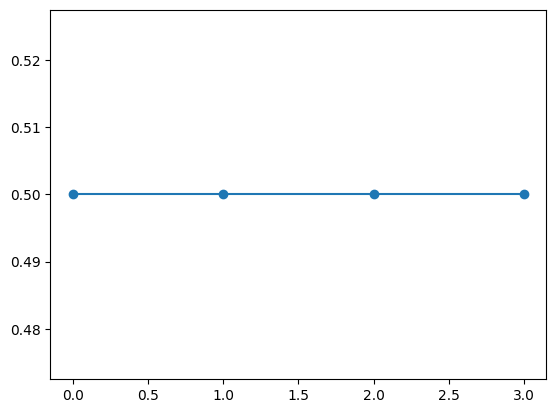

In [13]:
b = np.random.rand(size)
b = np.array([1,1,1,1])/2
# b = np.ones(size)
print("b = ", b)
plt.plot(b, "o-")

x/|x| = 
 [-0.05423261  0.3796283   0.59655876  0.70502399]


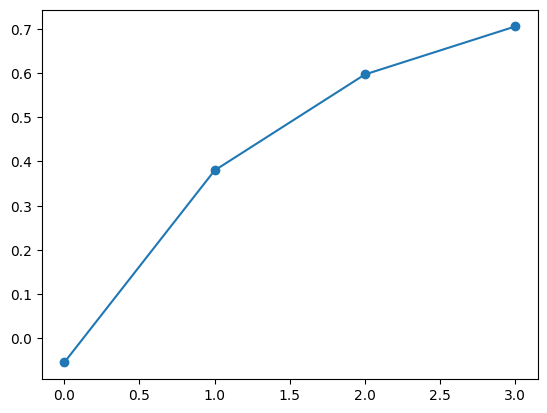

In [14]:
ref_solution = np.linalg.solve(A, b / np.linalg.norm(b))
ref_solution = ref_solution / np.linalg.norm(ref_solution)
print("x/|x| = \n", ref_solution)
plt.plot(ref_solution, "o-")

In [19]:
ansatz = RealAmplitudes(nqbit, entanglement="full", reps=4, insert_barriers=False)

In [29]:
log = VQLSLog([], [])
estimator = Estimator()
sampler = Sampler()
vqls = VQLS(
    estimator,
    ansatz,
    COBYLA(maxiter=300, disp=True, tol=1e-3),
#     L_BFGS_B(maxiter=5000, ftol=1e-4), 
#     CG(maxiter=5000, tol=1e-3),
    sampler=sampler,
    callback=log.update,
)

In [30]:
opt = {"use_overlap_test": True, "use_local_cost_function": False}
res = vqls.solve(A, b, opt)

VQLS Iteration 284 Cost 0.00010333870349055196
   Normal return from subroutine COBYLA

   NFVALS =  284   F = 1.033387E-04    MAXCV = 0.000000E+00
   X = 1.592514E+00   1.394055E+00   3.027523E+00  -8.979052E-01  -4.438809E-01
      -1.527291E+00  -2.379266E+00  -3.575562E+00   3.057792E+00   2.938701E+00


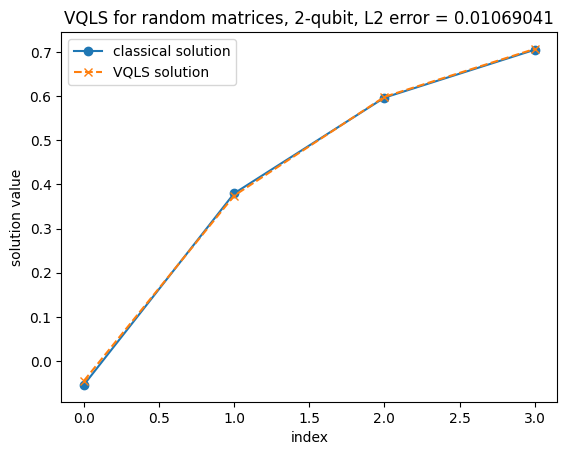

In [31]:
vqls_solution = np.real(Statevector(res.state).data)
err = np.linalg.norm(ref_solution - vqls_solution)

plt.plot(ref_solution, "o-", label="classical solution")
plt.plot(vqls_solution, "x--", label="VQLS solution")
plt.xlabel("index")
plt.ylabel("solution value")
plt.title("VQLS for random matrices, {0}-qubit, L2 error = {1:.8f}".format(nqbit, err))
plt.legend()
# plt.savefig("5-qubit 1D random Poisson", dpi=500)

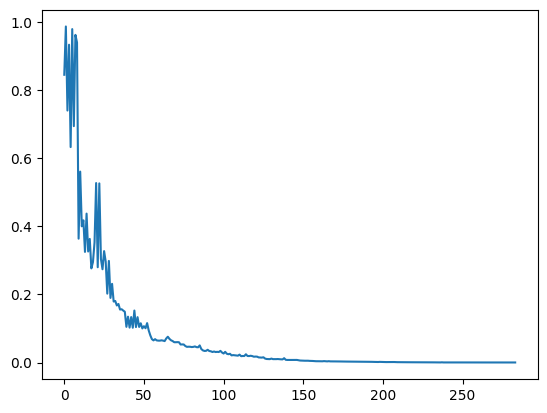

In [32]:
plt.plot(log.values)

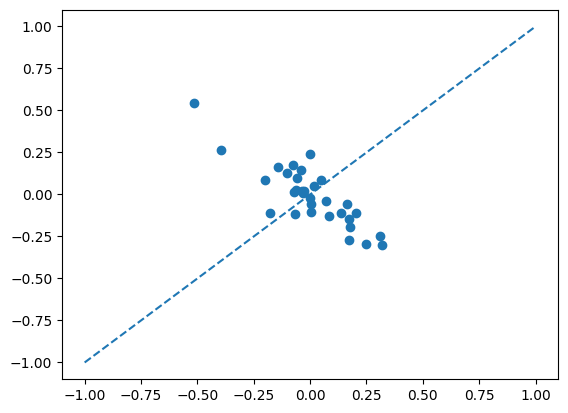

In [117]:
ref_solution = np.linalg.solve(A, b / np.linalg.norm(b))
ref_solution = ref_solution / np.linalg.norm(ref_solution)
vqls_solution = np.real(Statevector(res.state).data)

plt.scatter(ref_solution, vqls_solution)
plt.plot([-1, 1], [-1, 1], "--")

In [57]:
solutions = []
for p in log.parameters:
    qc = vqls.ansatz.assign_parameters(p)
    x = Statevector(qc.to_instruction()).data.real
    solutions.append(x)

/var/folders/3t/7ts1c6s95hq650lfkvk66tkh0000gn/T/ipykernel_49465/1727559487.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ref_solution, -s, c=[c] * 4, cmap="jet", s=10 * (1 - c), alpha=0.1)
/var/folders/3t/7ts1c6s95hq650lfkvk66tkh0000gn/T/ipykernel_49465/1727559487.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(ref_solution, -s, c=[c] * 4, cmap="jet", s=10 * (1 - c), alpha=0.1)


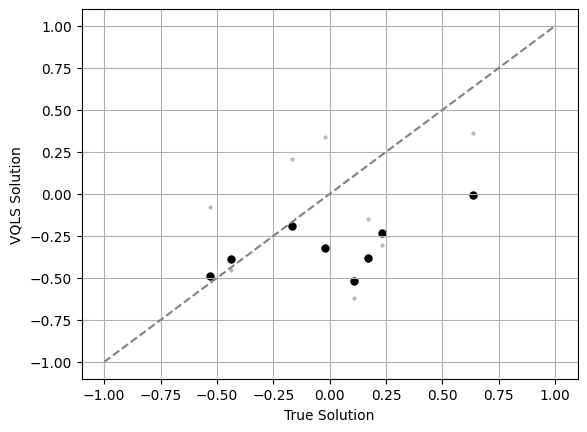

In [58]:
colors = log.values[:-1]
colors /= np.max(colors)
for img in range(1, 50):
    plt.cla()
    for c, s in zip(colors[: img - 1], solutions[: img - 1]):
        plt.scatter(ref_solution, -s, c=[c] * 4, cmap="jet", s=10 * (1 - c), alpha=0.1)
    plt.scatter(ref_solution, -solutions[img], s=50, edgecolors="white", c="black")
    plt.plot([-1, 1], [-1, 1], "--", c="grey")
    plt.grid()
    plt.xlabel("True Solution")
    plt.ylabel("VQLS Solution")
    # img_name = "./image/image_%03d.png" %img
    # plt.savefig(img_name)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import u_momentum, v_momentum, get_rhs, get_coeff_mat, pressure_correct, update_velocity, check_divergence_free


imax = 4                        # grid size in x-direction
jmax = 4                        # grid size in y-direction
max_iteration = 8000             # iterations
max_res = 1000                   # initial residual
rho = 1                          # density
velocity = 1                     # velocity = lid velocity
Re = 100                         # Reynolds number
mu = 1/Re                        # kinematic viscosity = 1/Reynolds number
dx = 1 / (imax - 1)              # dx, dy cell sizes along x and y directions
dy = 1 / (jmax - 1)
x = np.arange(dx / 2, 1 + dx/2 - dx / 2, dx)
y = np.arange(0, 1+dy/2, dy)
alpha_p = 0.1                    # pressure under-relaxation
alpha_u = 0.7                    # velocity under-relaxation
tol = 1e-5                       # tolerance for convergence

In [2]:
# Variable declaration
p = np.zeros((imax, jmax))             # p = Pressure
p_star = np.zeros((imax, jmax))        # intermediate pressure
p_prime = np.zeros((imax, jmax))       # pressure correction
rhsp = np.zeros((imax, jmax))          # right hand side vector of pressure correction equation
div = np.zeros((imax, jmax))

# Vertical velocity
v_star = np.zeros((imax, jmax + 1))    # intermediate velocity
v = np.zeros((imax, jmax + 1))         # final velocity
d_v = np.zeros((imax, jmax + 1))       # velocity correction coefficient

# Horizontal Velocity
u_star = np.zeros((imax + 1, jmax))    # intermediate velocity
u = np.zeros((imax + 1, jmax))         # final velocity
d_u = np.zeros((imax + 1, jmax))       # velocity correction coefficient

# Boundary condition
# Lid velocity (Top wall is moving with 1m/s)
u_star[:, jmax-1] = velocity
u[:, jmax-1] = velocity

### Main Algorithm

In [3]:
res_hist = []

iteration = 1
max_iteration = 10
while iteration <= max_iteration and max_res > tol:
    iteration += 1
    
    # Solve u and v momentum equations for intermediate velocity 
    u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alpha_u)
    v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alpha_u)

    u_old = u.copy()
    v_old = v.copy()

    # Calculate rhs vector of the Pressure Poisson matrix 
    rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)
    
    # Form the Pressure Poisson coefficient matrix 
    Ap = get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v)
    
    # Solve pressure correction implicitly and update pressure
    p, p_prime = pressure_correct(imax, jmax, rhsp, Ap, p_star, alpha_p)
    
    # Update velocity based on pressure correction
    u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity)
    
    # Check if velocity field is divergence free
    div = check_divergence_free(imax, jmax, dx, dy, u, v)

    p_star = p.copy()              # use p as p_star for the next iteration

    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist.append(max_res)

    # Check for convergence  
    if (iteration % 50) == 0:
        print(f"Iteration = {iteration}; Residual = {max_res}")
    
    if max_res > 2:
        print("not going to converge!")
        break

###  VQLS


In [9]:
b, num_qubits, list_A, coefficients_real, coefficients_img, original_dim, b_scale = preprocess(Ap, rhsp)

In [13]:
b.numpy()

array([ 0.0000000e+00+0.j, -4.7789179e-02+0.j,  1.0358404e-01+0.j,
        0.0000000e+00+0.j,  4.6104237e-01+0.j, -4.4661795e-04+0.j,
       -3.3703219e-02+0.j, -2.8701398e-01+0.j, -5.7113332e-01+0.j,
       -4.7868811e-02+0.j, -4.1677099e-02+0.j,  6.0048980e-01+0.j,
        0.0000000e+00+0.j, -1.7584891e-03+0.j, -1.0029729e-02+0.j,
        0.0000000e+00+0.j], dtype=complex64)

In [10]:
import paddle
from paddle_quantum.data_analysis.vqls import compute as vqls_solve

def pressure_correct_vqls(imax, jmax, rhsp, Ap, p, alpha, vqls_depth, vqls_itr, vqls_lr):
    pressure = np.copy(p)  # Initial pressure
    p_prime = np.zeros((imax, jmax))  # Pressure correction matrix
#     p_prime_interior = np.linalg.solve(Ap, rhsp)
    p_prime_interior = vqls_solve(A=Ap, b=rhsp, depth=vqls_depth, iterations=vqls_itr, LR=vqls_lr)


    z = 0  # Adjusted the indexing to start from 0
    for j in range(jmax):
        for i in range(imax):
            p_prime[i, j] = p_prime_interior[z]
            z += 1
            pressure[i, j] = p[i, j] + alpha * p_prime[i, j]

    pressure[0, 0] = 0  # Set the pressure at the first node to zero

    return pressure, p_prime

In [28]:
x = np.linalg.solve(Ap, rhsp)
print(x)

[-3.64212584e-17  1.94323481e-03  5.52249586e-03  5.92133743e-03
  2.09772200e-03  1.89854642e-03  4.90300372e-03  6.39697852e-03
 -1.04240747e-02 -8.49768213e-04  7.31984394e-03  1.90633680e-02
 -6.87056661e-03 -5.25752227e-04  7.10333005e-03  1.84051983e-02]


In [38]:
vqls_x = vqls_solve(A=Ap, b=rhsp, depth=8, iterations=200, LR=0.01, gamma=0.001)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:25<00:00,  1.37it/s]


In [39]:
print(vqls_x.real)
relative_error = np.linalg.norm(rhsp- np.matmul(Ap,vqls_x.real))/np.linalg.norm(rhsp)
print('Relative error: ', relative_error)

[ 0.00118953 -0.00040313 -0.00052735 -0.00145211  0.0006023  -0.00101796
 -0.00136184 -0.00178312 -0.00635696 -0.00299238 -0.00065392  0.00412941
 -0.00252932 -0.00237778 -0.00277723  0.00331631]
Relative error:  0.4986904421963233


In [40]:
np.linalg.norm(x)

0.033247064986836404

In [41]:
np.linalg.norm(vqls_x)

0.010392523

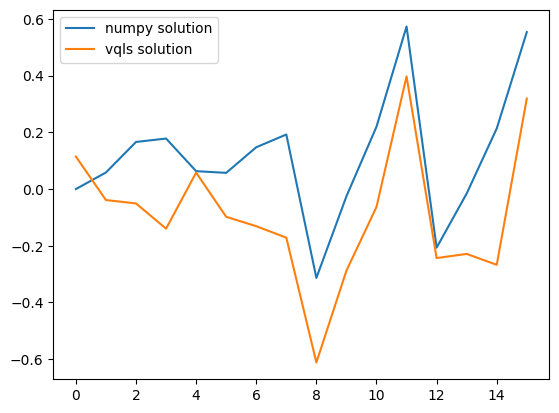

In [42]:
plt.plot(x/np.linalg.norm(x), label = "numpy solution")
plt.plot(vqls_x/np.linalg.norm(vqls_x), label = "vqls solution")
plt.legend()

In [24]:
n = 16
import numpy as np
np.random.seed(1)
A = np.zeros([n, n], dtype="complex64")
b = np.zeros(n, dtype="complex64")
for i in range(n):
    for j in range(n):
        x = np.random.rand() * 10
        y = np.random.rand() * 10
        A[i][j] = complex(x, y)
    x = np.random.rand() * 10
    y = np.random.rand() * 10
    b[i] = complex(x, y)

In [25]:
result = vqls_solve(A, b, depth=5, iterations=200, LR=0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:21<00:00,  1.42it/s]


In [26]:
print("Here is x that solves Ax=b:", result)
print("This is actual b:", b)
print("This is Ax using estimated x:", np.matmul(A, result))
relative_error = np.linalg.norm(b - np.matmul(A, result)) / np.linalg.norm(b)
print("Relative error: ", relative_error)

Here is x that solves Ax=b: [ 0.58388877-0.06403625j -0.01302814+0.00142882j  0.23299268-0.02555278j
 -0.02624841+0.00287872j -0.15784475+0.01731115j  0.26781207-0.02937149j
  0.0789975 -0.00866381j -0.1820859 +0.01996973j  0.00147642-0.00016192j
 -0.14403251+0.01579633j -0.01548028+0.00169775j -0.03766212+0.00413048j
  0.13621816-0.01493932j -0.2957556 +0.03243611j -0.04409847+0.00483637j
  0.46591237-0.05109754j]
This is actual b: [9.578896  +5.3316526j  6.6379466 +5.148891j   3.266449  +5.2705812j
 8.006327  +2.3297427j  6.0632944 +5.688514j   9.156063  +6.4156623j
 0.15533276+5.934814j   4.014796  +3.1738396j  1.6097144 +4.6688004j
 8.447096  +5.384406j   1.6039518 +7.456372j   2.2143273 +2.67072j
 6.185136  +0.10364261j 9.3888645 +0.30949005j 7.0187654 +2.4035563j
 4.6862836 +4.574049j  ]
This is Ax using estimated x: [4.962575  +6.2753496j  4.121588  +4.446777j   4.5662074 +6.9643145j
 8.668262  +3.2776074j  4.8835382 +0.92494977j 9.644716  +6.111086j
 4.9017253 +6.7241015j  4.15

Text(0, 0.5, 'value')

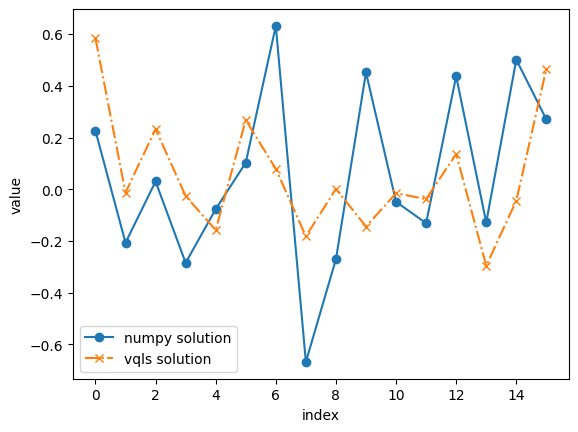

In [27]:
x = np.linalg.solve(A,b)
plt.plot(x, 'o-', label = "numpy solution")
plt.plot(result, 'x-.', label = "vqls solution")
plt.legend()
plt.xlabel("index")
plt.ylabel("value")

### Visualization

Final Iteration = 11; Residual = 0.005313883650138088


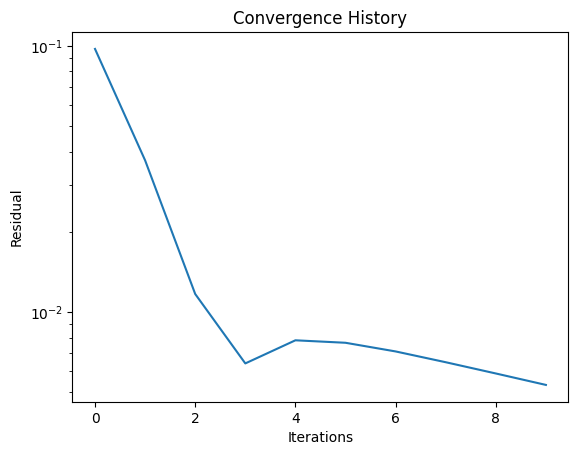

In [24]:
# Final residual        
print(f"Final Iteration = {iteration}; Residual = {max_res}")
plt.plot(np.arange(iteration)[0:-1], res_hist)
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.title("Convergence History")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

Ap Matrix Condition Number =  478.2686775905757


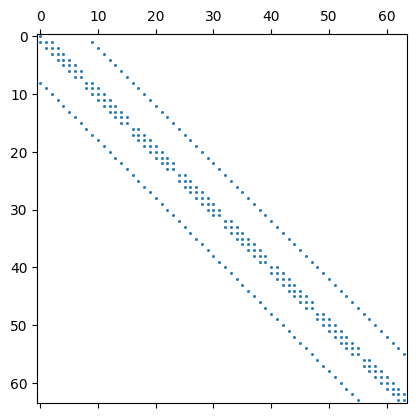

In [16]:
# Check sparse pattern
print("Ap Matrix Condition Number = ", np.linalg.cond(Ap))
plt.spy(Ap[0:64, 0:64], markersize=1)
plt.show()

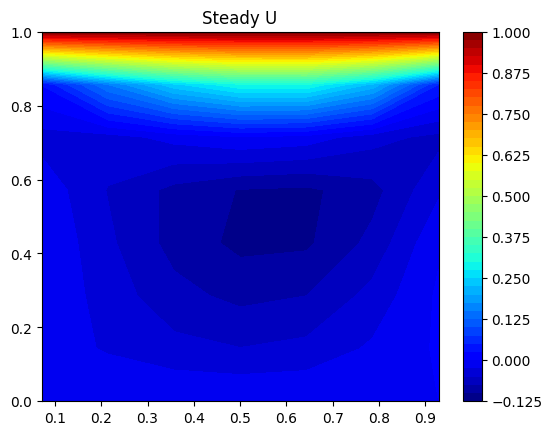

In [17]:
X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u[1:imax,:].T, 50, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

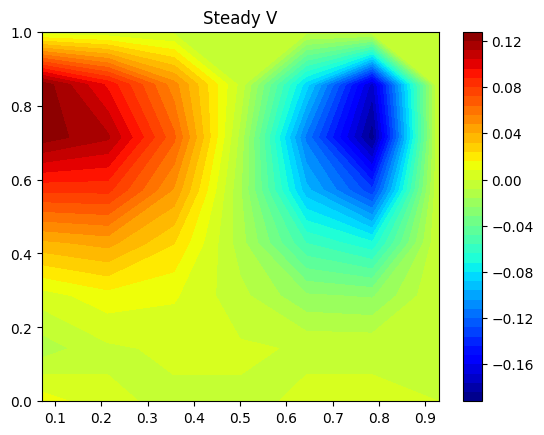

In [18]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, v[1:imax, 0:jmax].T, 50, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady V")
plt.show()

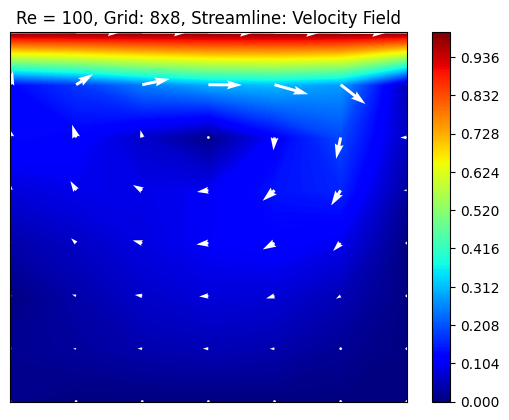

In [19]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, np.sqrt(u[1:imax,:].T**2 + v[1:imax, 0:jmax].T**2), 300, cmap='jet')
plt.colorbar()
# skip = (slice(None, None, 2), slice(None, None, 2))
plt.quiver(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, color='w')
plt.title('Re = {0}, Grid: {1}x{2}, Streamline: Velocity Field'.format(Re, imax, jmax))
plt.xticks([])
plt.yticks([])
# plt.savefig("./Benchmark/Re{0}/Stream_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)
plt.show()

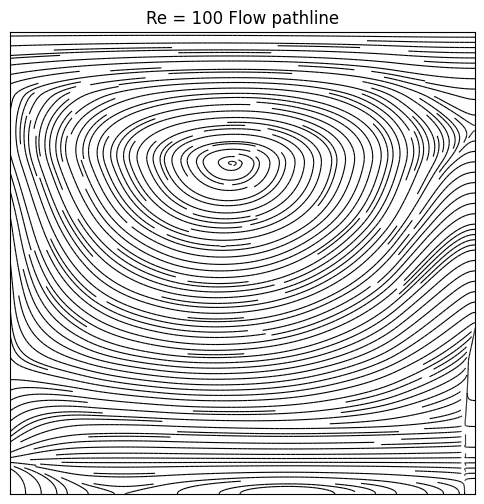

In [20]:
plt.figure(figsize=(6,6))
X, Y = np.meshgrid(x, y)
plt.streamplot(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, density=3, linewidth=0.8, arrowsize=0., color='k')
plt.title("Re = {0} Flow pathline".format(Re))
plt.xticks([])
plt.yticks([])
plt.show()

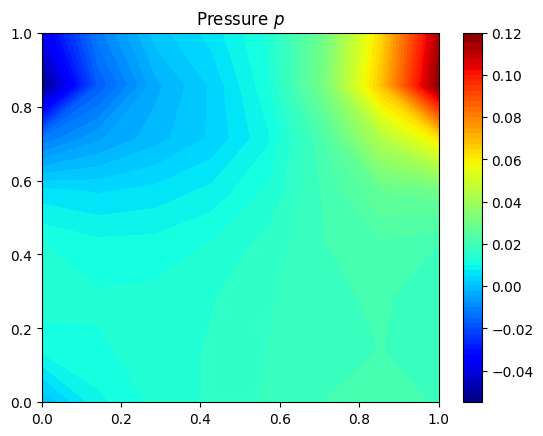

In [21]:
X, Y = np.meshgrid(y, y)
plt.figure()
plt.contourf(X, Y, p.T, 80, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('Pressure $p$')
plt.show()

### Benchmark with literature data

Ghia, U. K. N. G., Kirti N. Ghia, and C. T. Shin. "High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method." Journal of computational physics 48.3 (1982): 387-411.

In [22]:
GhiaU = np.loadtxt('./benchmark/GhiaU.txt', skiprows=1)
GhiaV = np.loadtxt('./benchmark/GhiaV.txt', skiprows=1)
y_Ghia = GhiaU[:, 0]
x_Ghia = GhiaV[:, 0]

In [23]:
# Understand what's inside the benchmark data
import pandas as pd
# pd.set_option('display.max_columns', None)
df = pd.read_table("./benchmark/GhiaU.txt", skiprows=0, delimiter='\r')
print(df)

   # Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). 
0   # High-Re solutions for incompressible flow us...      
1   # Journal of computational physics, 48(3), 387...      
2                                                   #      
3                                           # TABLE I      
4   # Results for $u$-velocity along Vertical Line...      
5   #---------------------------------------------...      
6              #                                   Re      
7   #       --------------------------------------...      
8   #  y      100      400      1000     3200     ...      
9   #---------------------------------------------...      
10  1.0000  1.00000  1.00000  1.00000  1.00000  1....      
11  0.9766  0.84123  0.75837  0.65928  0.53236  0....      
12  0.9688  0.78871  0.68439  0.57492  0.48296  0....      
13  0.9609  0.73722  0.61756  0.51117  0.46547  0....      
14  0.9531  0.68717  0.55892  0.46604  0.46101  0....      
15  0.8516  0.23151  0.29093  0.33304  0

#### Re = 100

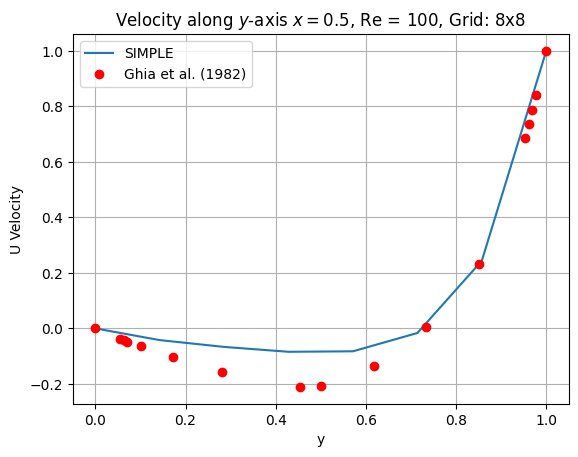

In [24]:
xmid_idx = int(imax/2-1)      # only works for even number
plt.plot(y, u[xmid_idx,:].T, label="SIMPLE")
plt.plot(y_Ghia, GhiaU[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.title("Velocity along $y$-axis $x=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
# plt.savefig("./Benchmark/Re{0}/UBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

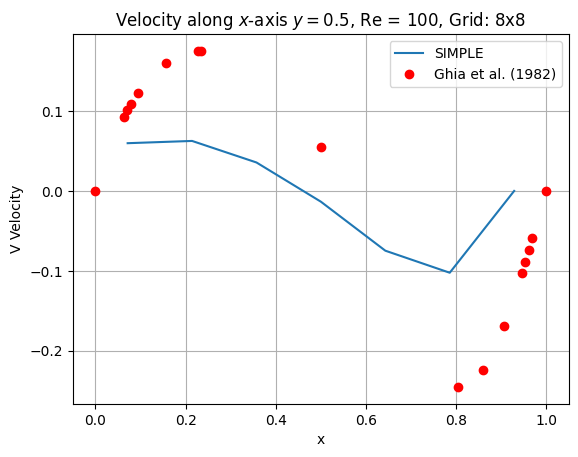

In [25]:
ymid_lidx = int(imax/2-1)      # only works for even number
v_profile = (v[1:imax, ymid_lidx].T + v[1:imax, ymid_lidx+1].T)/2
plt.plot(x, v_profile, label="SIMPLE")
plt.plot(x_Ghia, GhiaV[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("x")
plt.ylabel("V Velocity")
plt.title("Velocity along $x$-axis $y=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
# plt.savefig("./Benchmark/Re{0}/VBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

#### Re = 400

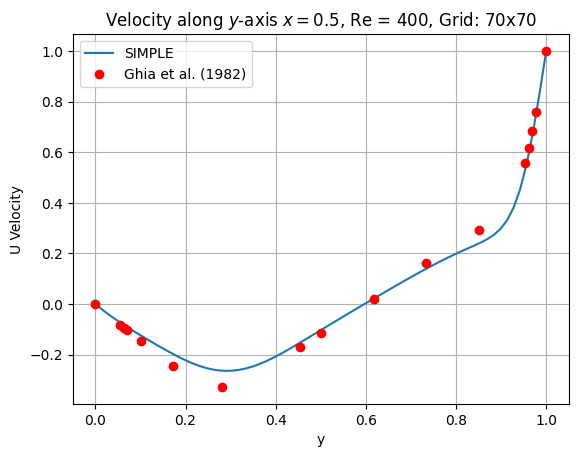

In [105]:
xmid_idx = int(imax/2-1)      # only works for even number
plt.plot(y, u[xmid_idx,:].T, label="SIMPLE")
plt.plot(y_Ghia, GhiaU[:, 2], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.title("Velocity along $y$-axis $x=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/UBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

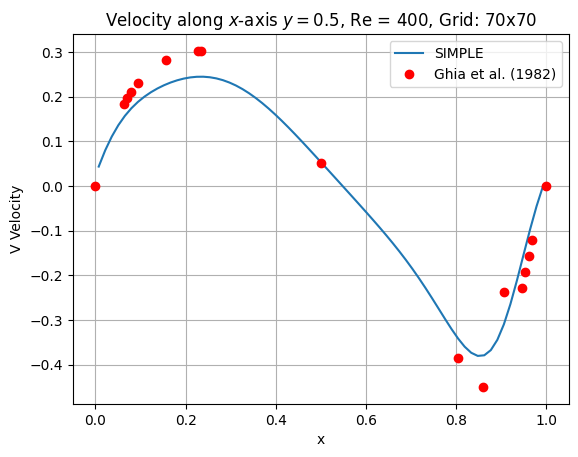

In [106]:
ymid_lidx = int(imax/2-1)      # only works for even number
v_profile = (v[1:imax, ymid_lidx].T + v[1:imax, ymid_lidx+1].T)/2
plt.plot(x, v_profile, label="SIMPLE")
plt.plot(x_Ghia, GhiaV[:, 2], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("x")
plt.ylabel("V Velocity")
plt.title("Velocity along $x$-axis $y=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/VBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)